In [1]:
import sys
import os

# Add the build directory to Python path
build_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib')
sys.path.insert(0, build_dir)

# Add the data directory to Python path
data_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data')
sys.path.insert(0, data_dir)

import pandas as pd
import numpy as np
from tqdm import tqdm

import sorters
import probes
import time

import list_generators as lg

In [2]:
data = pd.read_feather("/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data/out.feather")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33517 entries, 0 to 33516
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    33517 non-null  object
dtypes: object(1)
memory usage: 262.0+ KB


In [3]:
large_data = pd.read_feather("/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data/large_data.feather")
large_data

df_five = data.head(5000)
large_data = large_data.rename(columns={'large_data': 'data'})

df = pd.concat([df_five, large_data], axis=0, ignore_index=True)
df

,data
0,[]
1,"[0, 1, 2, 3, 4, 5, 6, 13, 8, 9, 44, 11, 12, 7,..."
2,"[47, 46, 45, 10, 43, 42, 41, 40, 39, 38, 37, 3..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 33, 9, 10, 11, 12, 13..."
4,"[47, 46, 45, 44, 43, 42, 24, 21, 39, 38, 37, 3..."
...,...
5095,"[258954, 1595072, 825979, 1349641, 364764, 893..."
5096,"[926767, 678666, 260400, 326220, 738716, 19058..."
5097,"[1873071, 1812489, 1076039, 42319, 387662, 150..."
5098,"[1911426, 142294, 456497, 561860, 882077, 1946..."


In [4]:
sorts = sorters.list_sorters()
sorts.remove('insertion_sort') # takes too long. we know what insertion sort is like anyway
sorts

['merge_sort', 'quick_sort', 'spin_sort', 'std_sort', 'tim_sort']

In [5]:
tqdm.pandas()  

for sorter in tqdm(sorts):
    df[sorter] = df['data'].progress_apply(lambda lst: sorters.benchmark_sorter(sorter, lst))

100%|██████████| 5/5 [00:48<00:00,  9.62s/it]


            merge_sort  quick_sort  spin_sort  std_sort  tim_sort
merge_sort    1.000000    0.998201   0.997743  0.998096  0.997294
quick_sort    0.998201    1.000000   0.999138  0.999368  0.998808
spin_sort     0.997743    0.999138   1.000000  0.999084  0.998172
std_sort      0.998096    0.999368   0.999084  1.000000  0.998414
tim_sort      0.997294    0.998808   0.998172  0.998414  1.000000


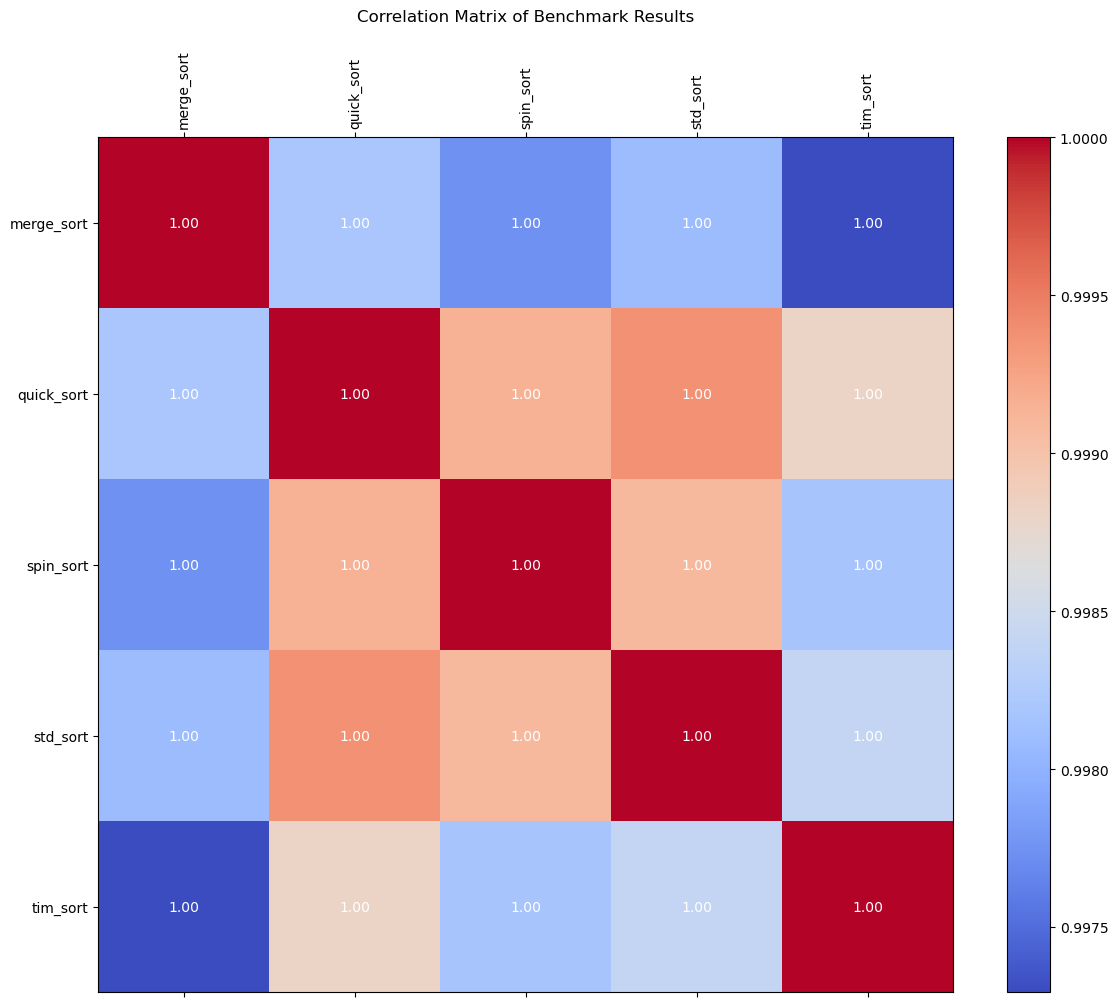

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Keep only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

print(corr_matrix)

fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

plt.title("Correlation Matrix of Benchmark Results", pad=20)
fig.colorbar(cax)
plt.tight_layout()
plt.show()


In [7]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri = corr_matrix.where(mask)
sorted_corrs = upper_tri.stack().abs().sort_values(ascending=False)

print("Highest correlations between sorter benchmarks:")
print(sorted_corrs)

Highest correlations between sorter benchmarks:
quick_sort  std_sort      0.999368
            spin_sort     0.999138
spin_sort   std_sort      0.999084
quick_sort  tim_sort      0.998808
std_sort    tim_sort      0.998414
merge_sort  quick_sort    0.998201
spin_sort   tim_sort      0.998172
merge_sort  std_sort      0.998096
            spin_sort     0.997743
            tim_sort      0.997294
dtype: float64


High correlation pairs (corr > 0.9):
merge_sort and quick_sort (corr = 1.00)
merge_sort and spin_sort (corr = 1.00)
merge_sort and std_sort (corr = 1.00)
merge_sort and tim_sort (corr = 1.00)
quick_sort and spin_sort (corr = 1.00)
quick_sort and std_sort (corr = 1.00)
quick_sort and tim_sort (corr = 1.00)
spin_sort and std_sort (corr = 1.00)
spin_sort and tim_sort (corr = 1.00)
std_sort and tim_sort (corr = 1.00)


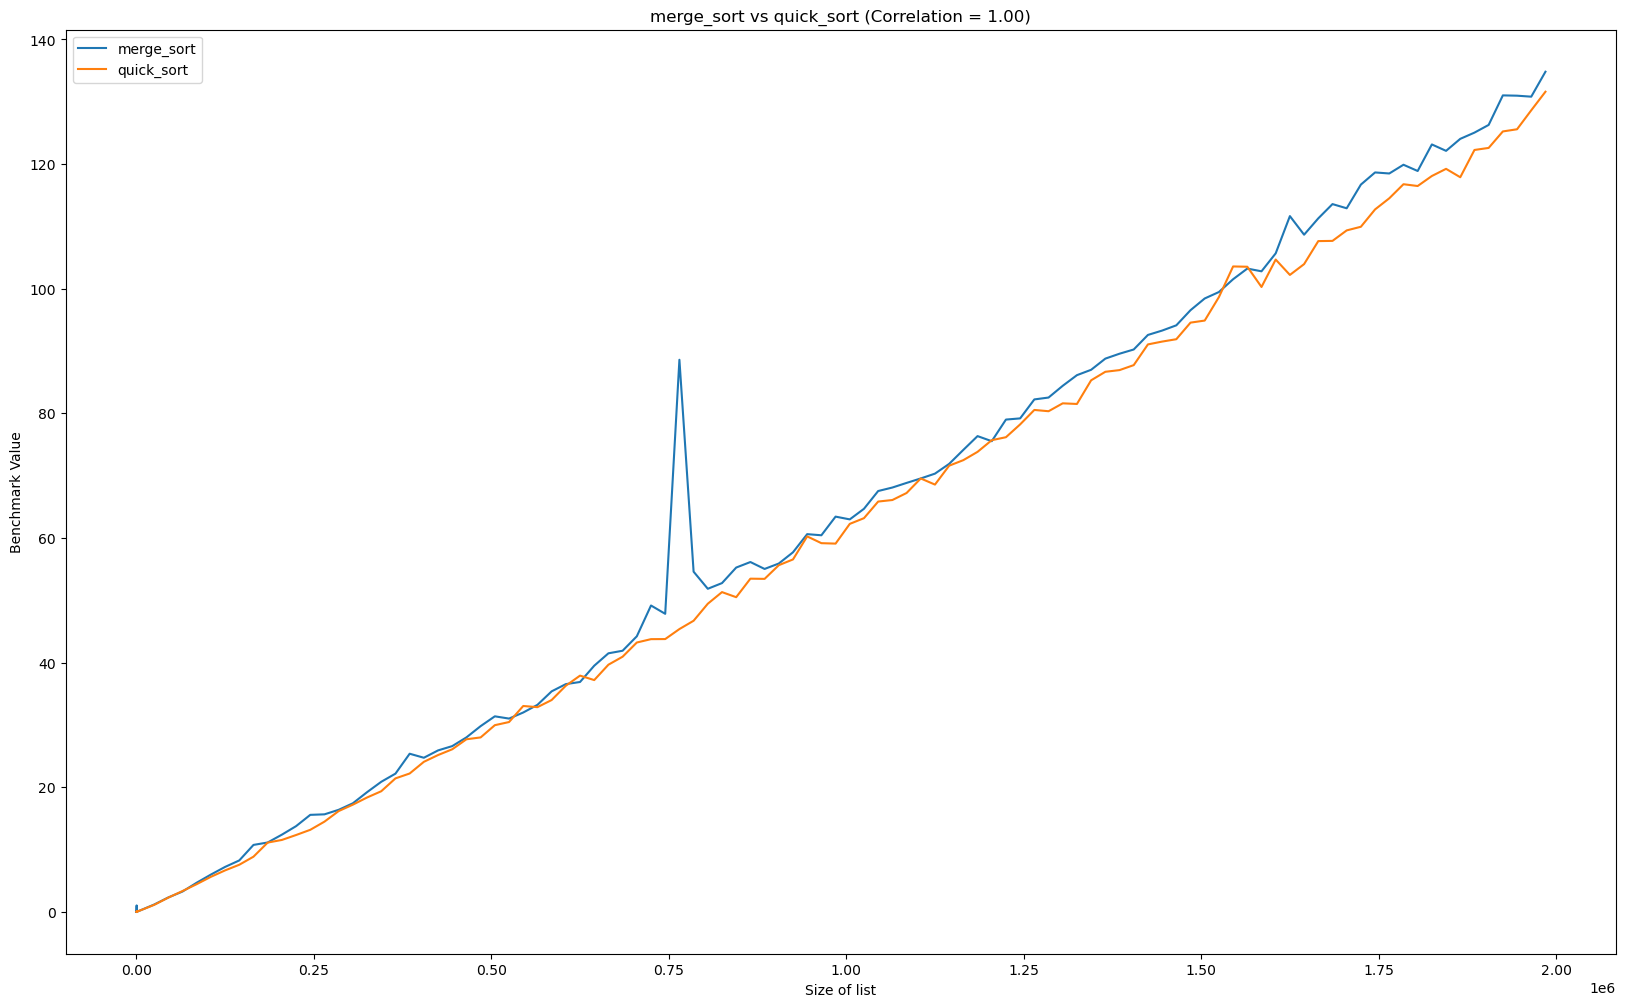

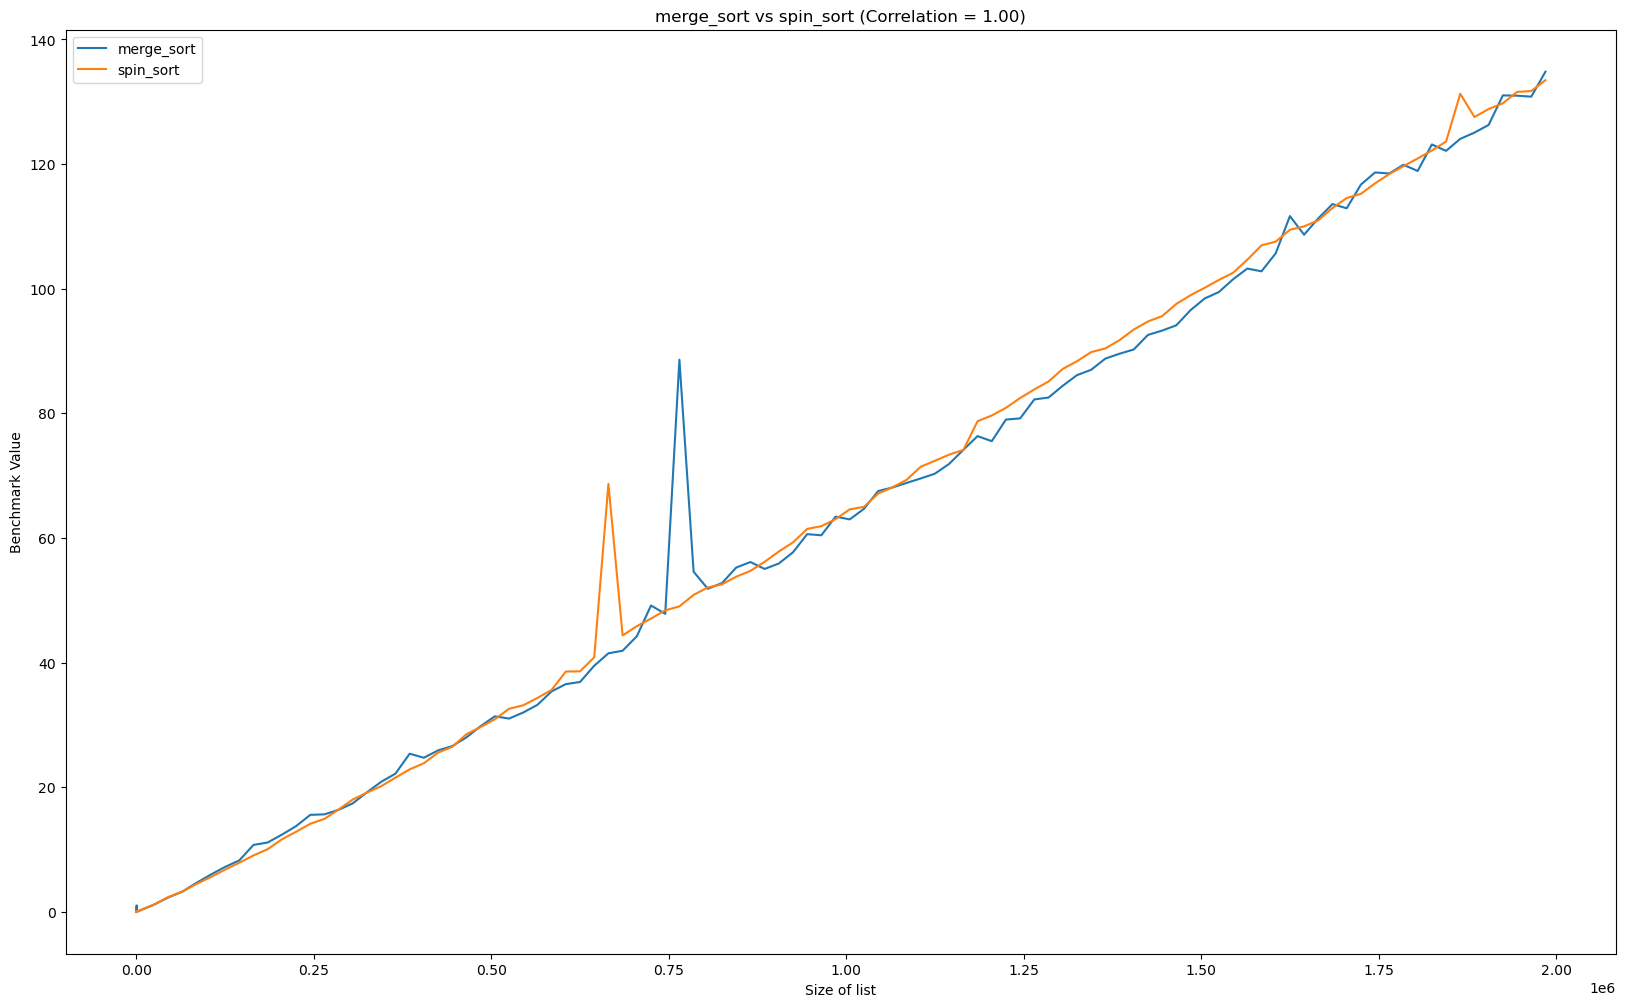

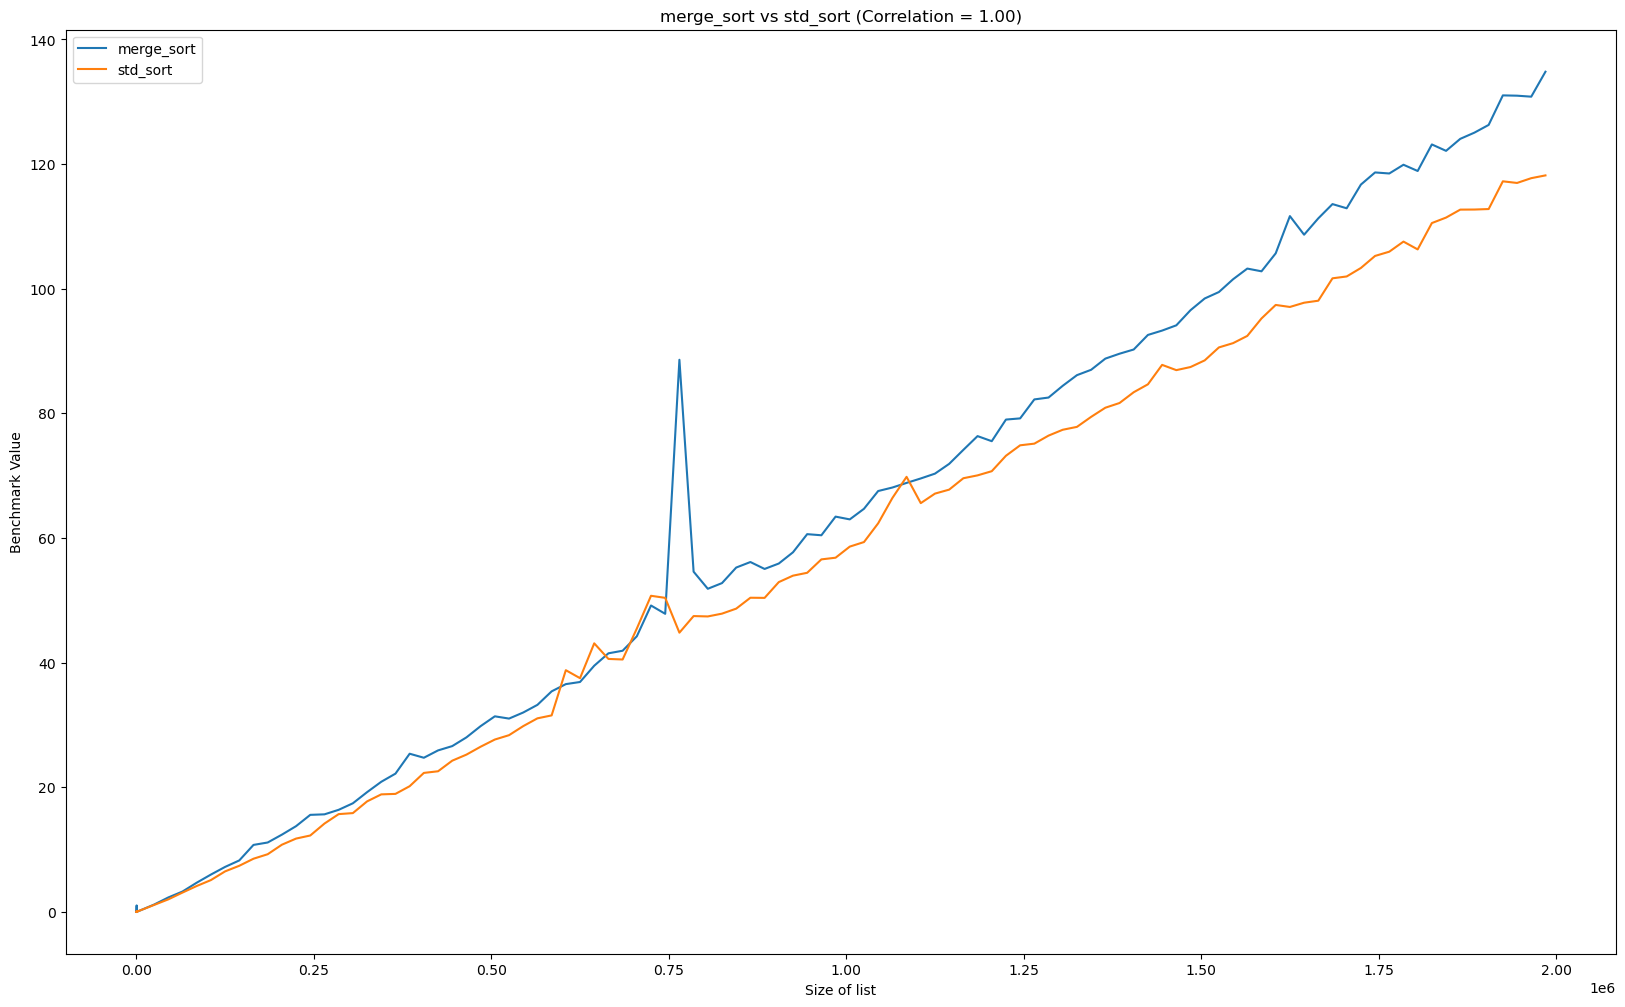

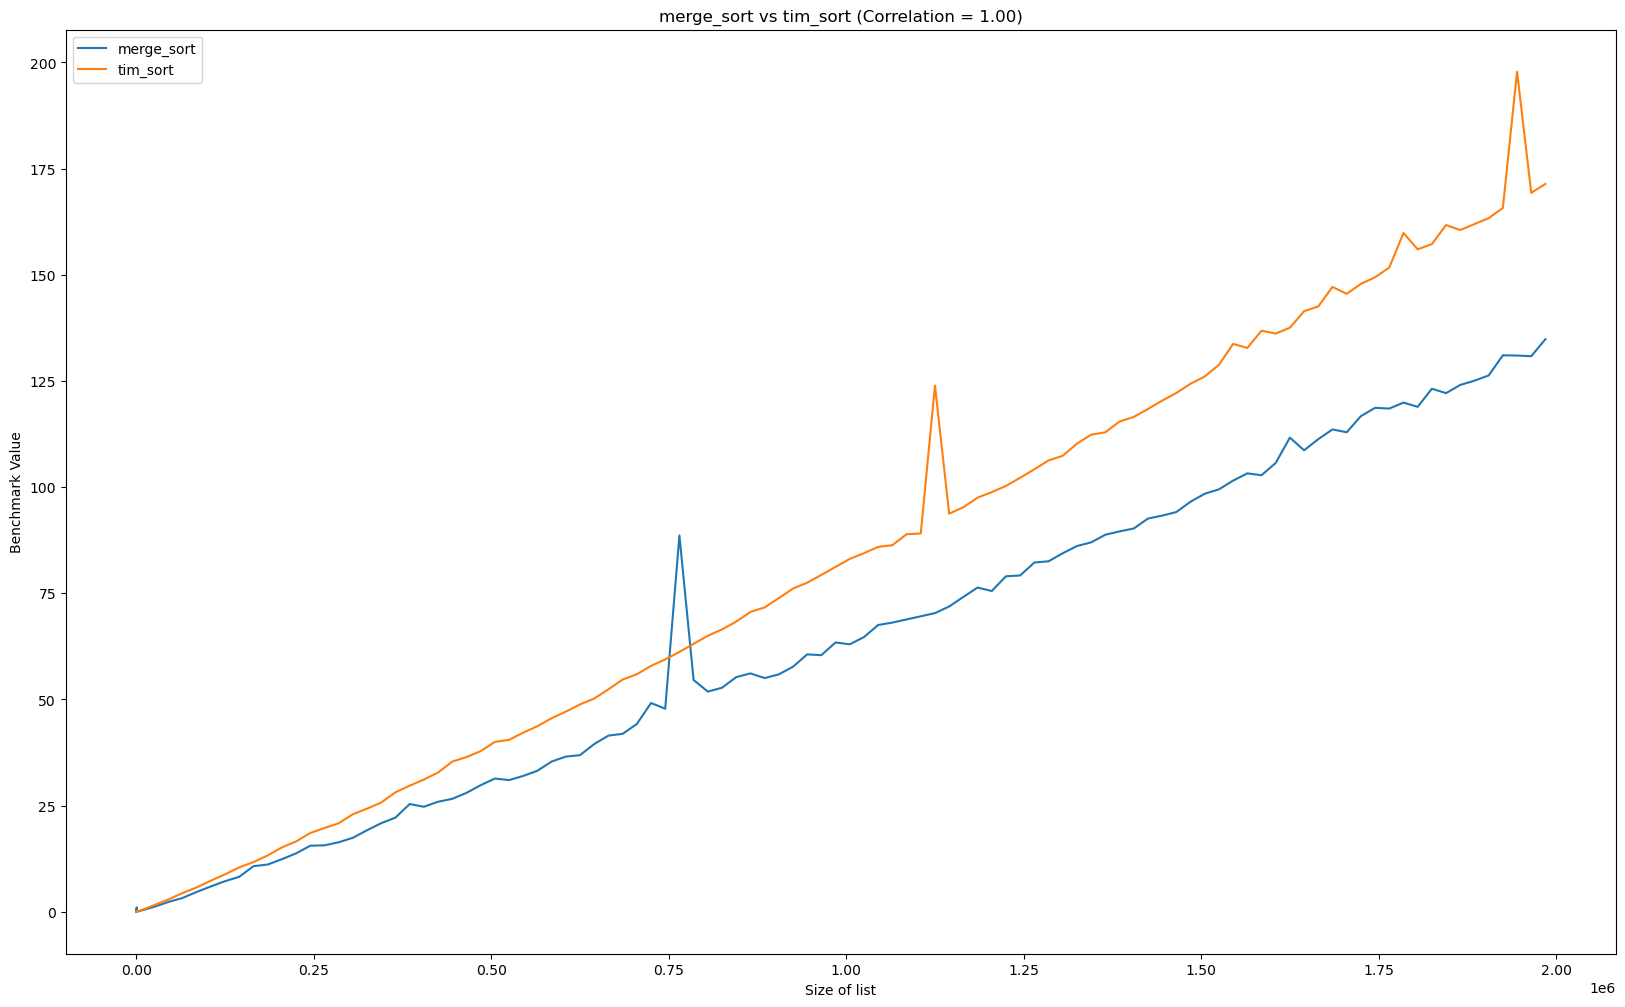

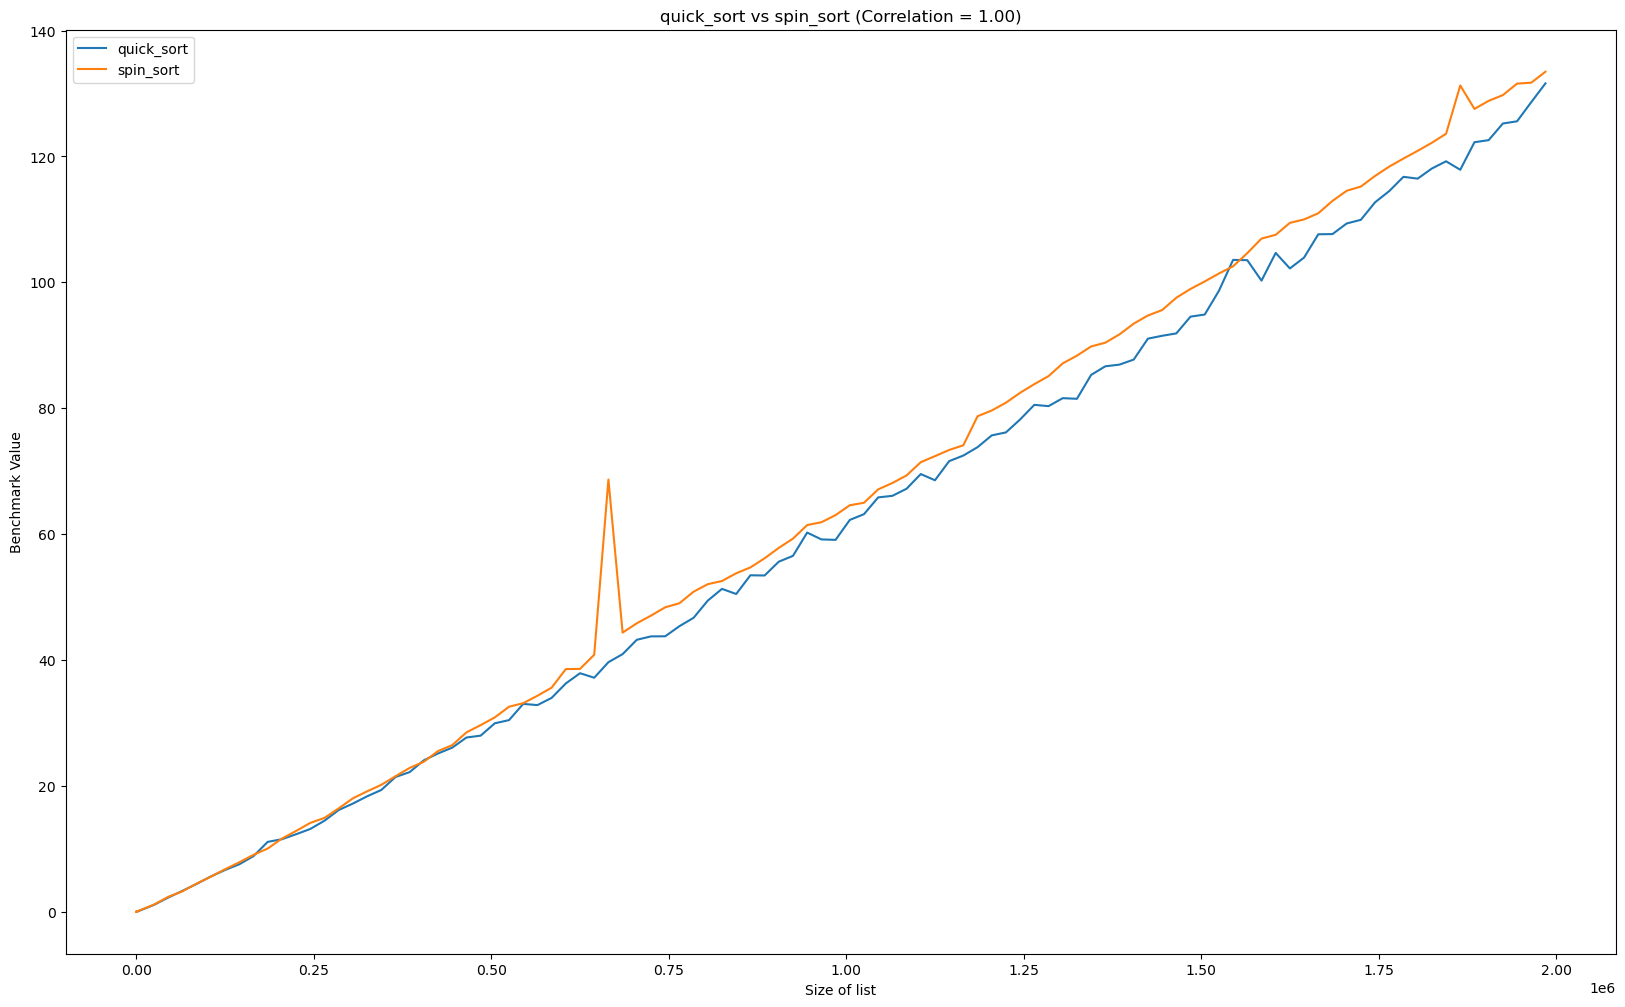

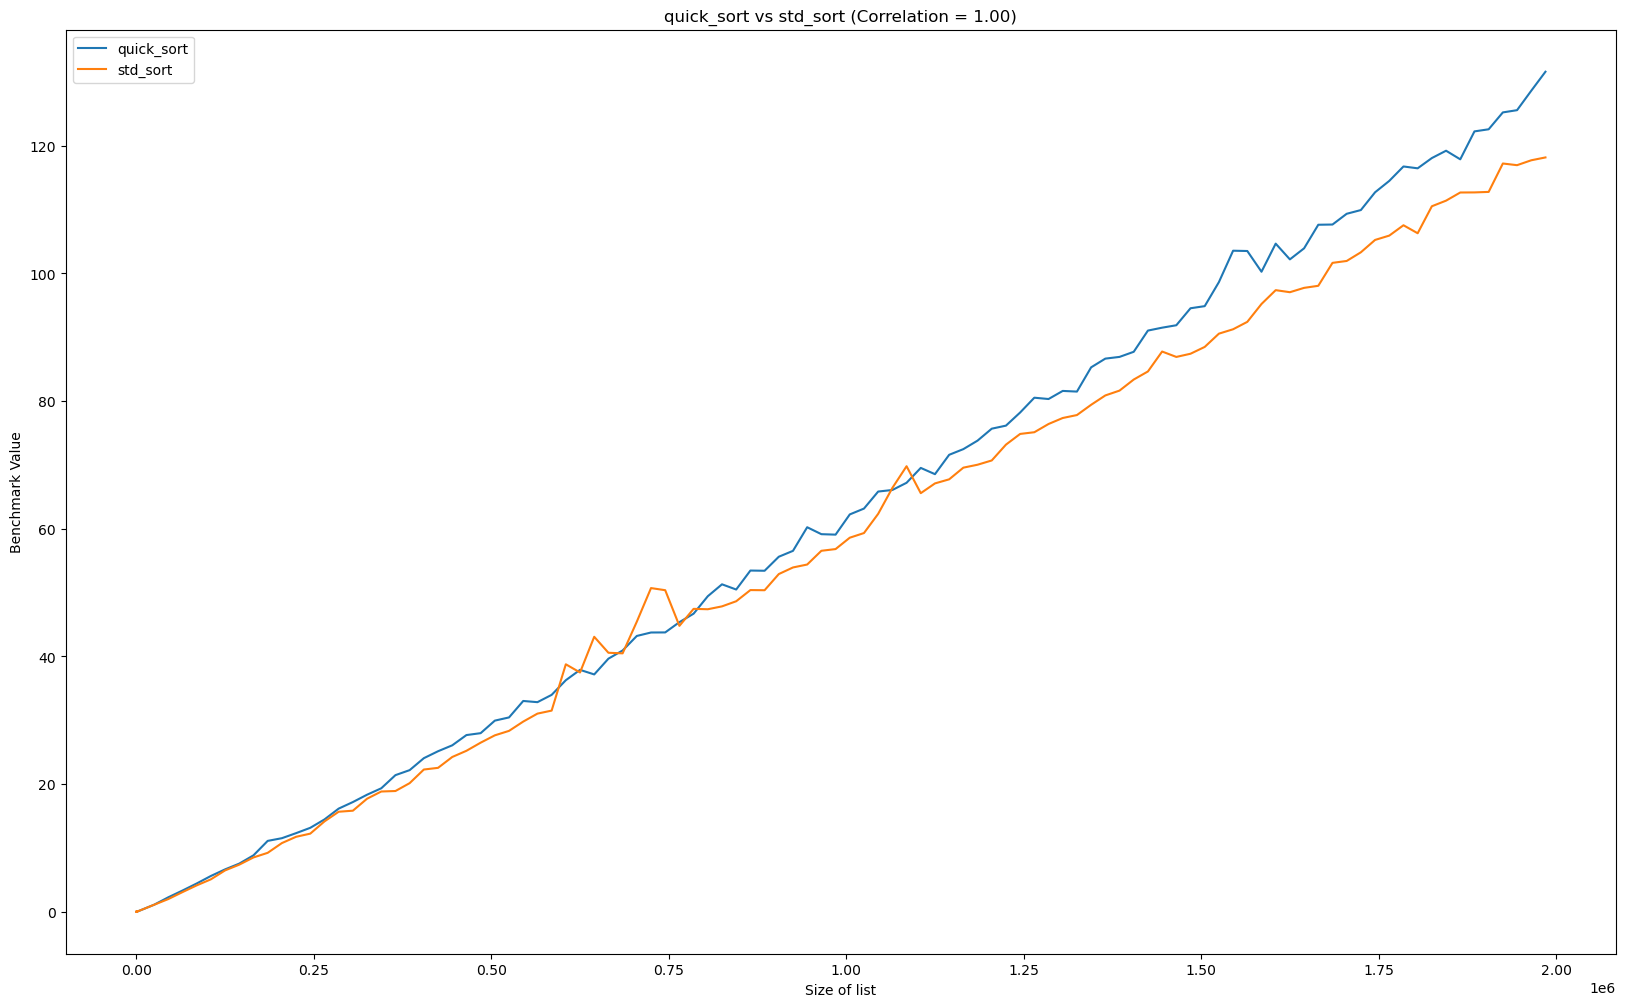

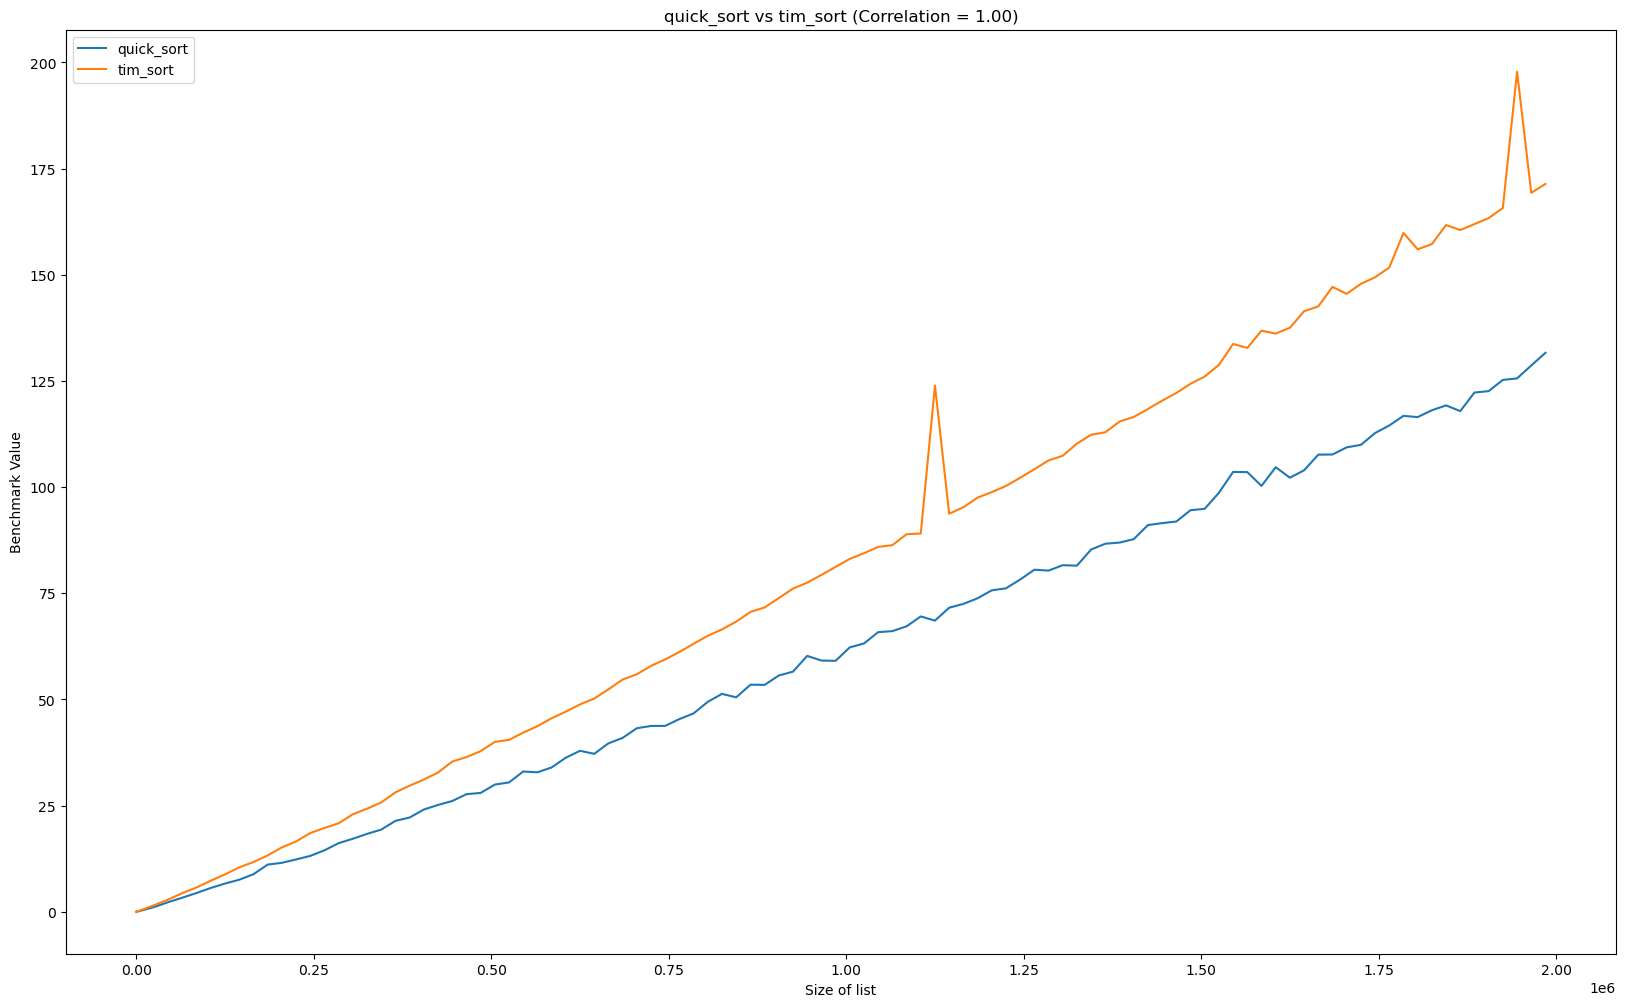

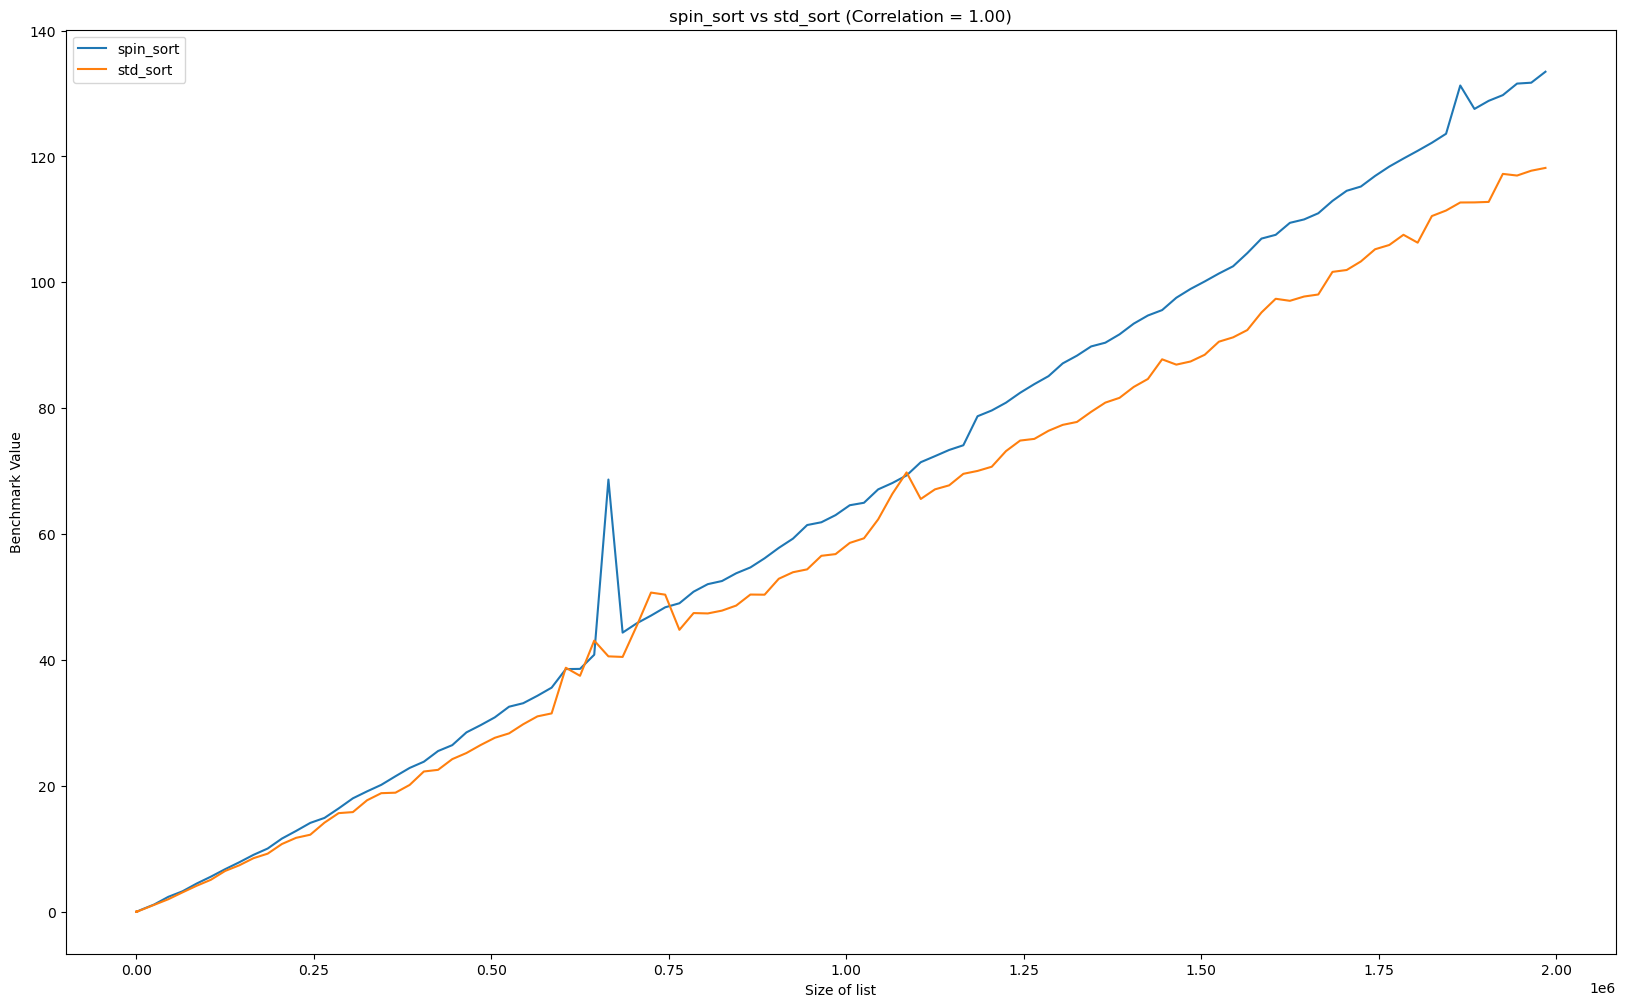

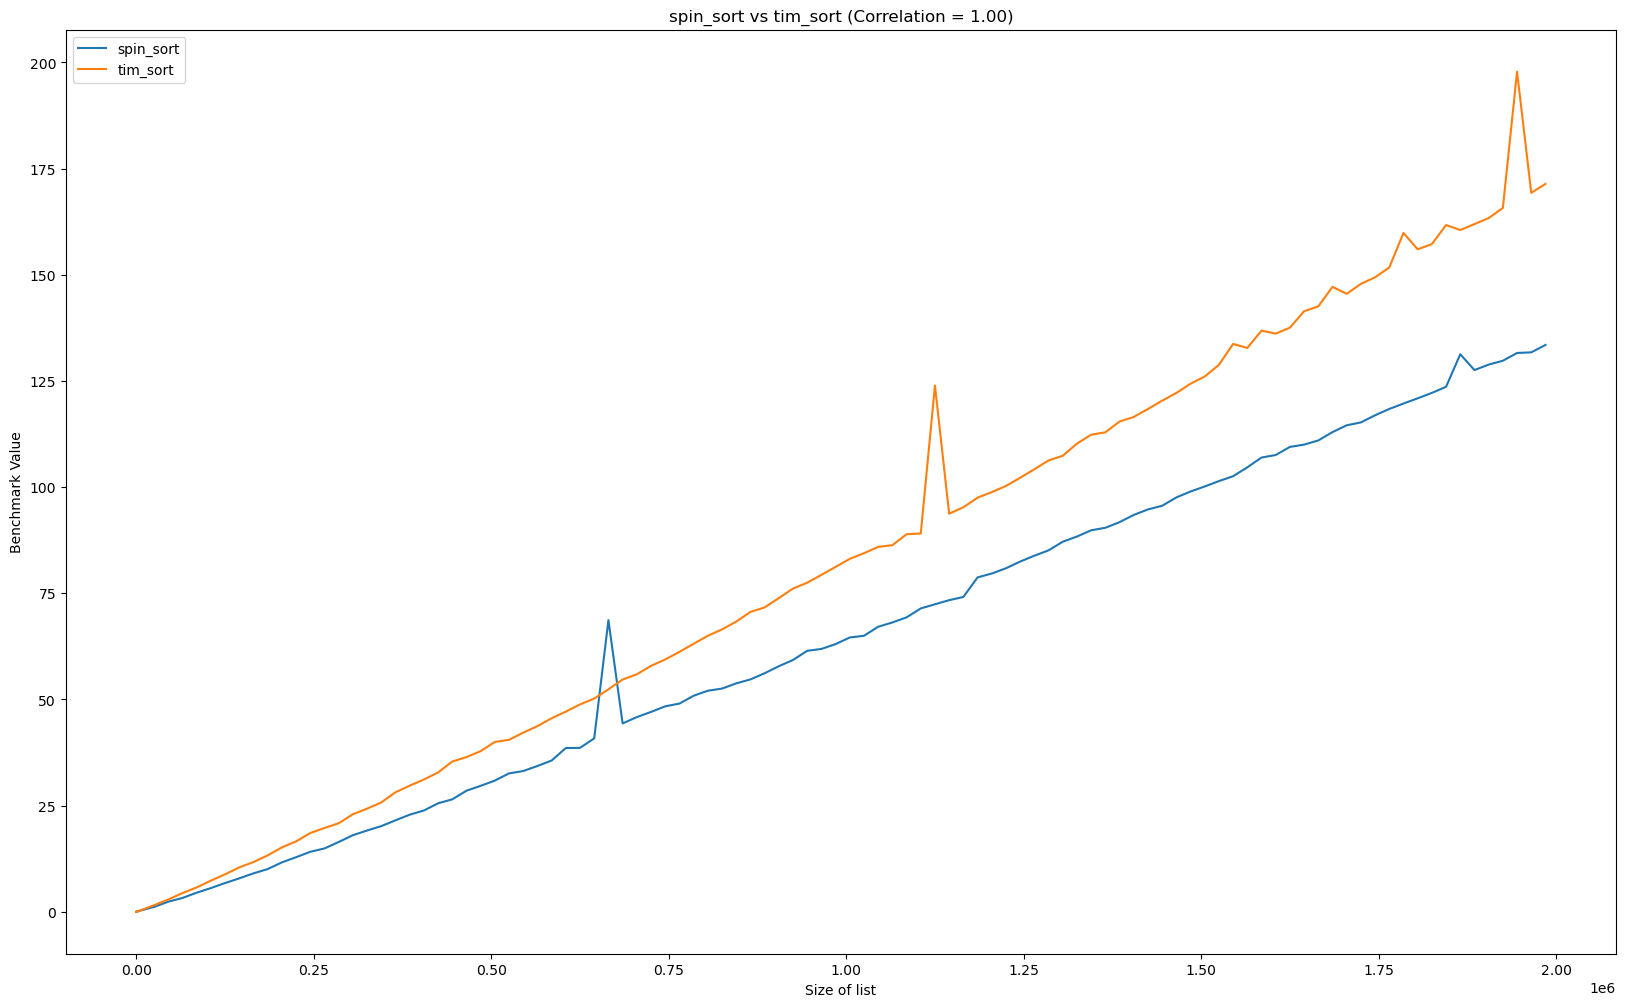

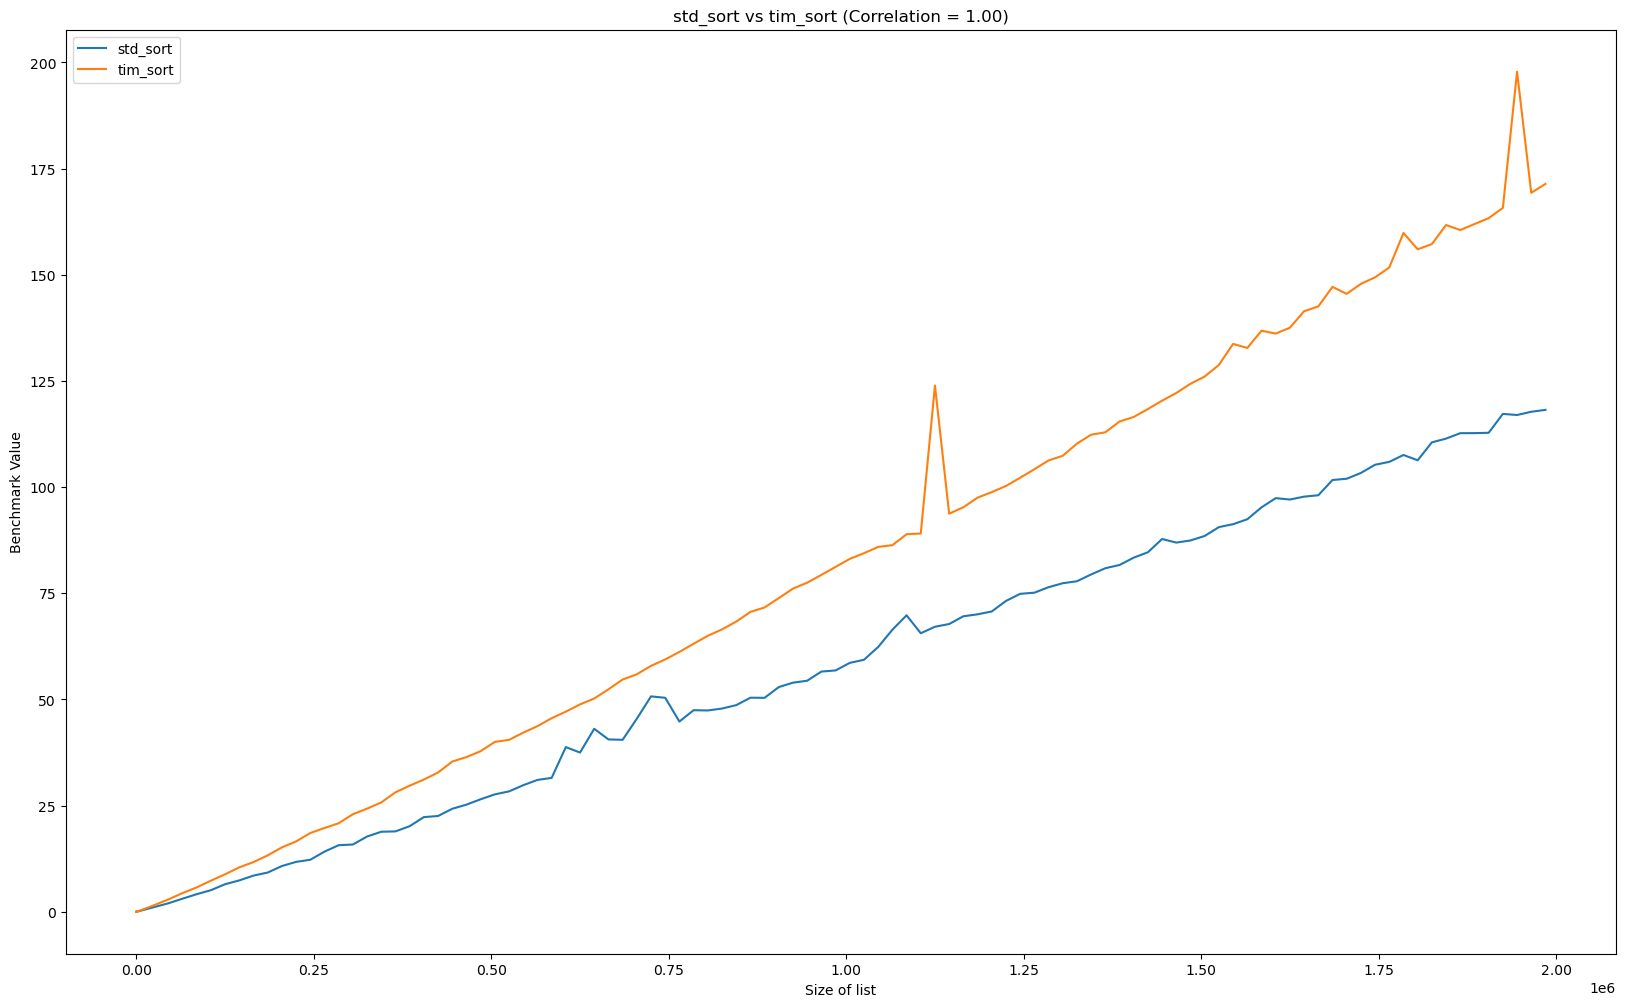

In [8]:
# Assuming benchmark_cols and corr_matrix are defined as before:
benchmark_cols = [col for col in df.columns if col != 'data']
corr_matrix = df[benchmark_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri = corr_matrix.where(mask)

high_corr_pairs = upper_tri.stack()[upper_tri.stack() > 0.95].index.tolist()

print("High correlation pairs (corr > 0.9):")
for col1, col2 in high_corr_pairs:
    print(f"{col1} and {col2} (corr = {corr_matrix.loc[col1, col2]:.2f})")

# Create a new column 'list_size' based on the size of each list in the 'data' column
df['list_size'] = df['data'].apply(len)

# Plot using the 'list_size' as the x-axis
for col1, col2 in high_corr_pairs:
    plt.figure(figsize=(20, 12))
    plt.plot(df['list_size'], df[col1], label=col1)
    plt.plot(df['list_size'], df[col2], label=col2)
    corr_value = corr_matrix.loc[col1, col2]
    plt.title(f'{col1} vs {col2} (Correlation = {corr_value:.2f})')
    plt.xlabel('Size of list')
    plt.ylabel('Benchmark Value')
    plt.legend()
    plt.show()


In [9]:
import pandas as pd

race_results = {}

for col1, col2 in high_corr_pairs:
    race_df = pd.DataFrame({
        f'{col1}_time': df[col1],
        f'{col2}_time': df[col2]
    })
    race_df[f'{col1}_winner'] = (race_df[f'{col1}_time'] < race_df[f'{col2}_time']).astype(int)
    race_results[(col1, col2)] = race_df

threshold = 0.95  # Overwhelming win threshold (90%)
print("Pairs with an overwhelming winner:")
for pair, race_df in race_results.items():
    col1, col2 = pair
    win_rate = race_df[f'{col1}_winner'].mean()  # Fraction where col1 wins
    if win_rate >= threshold:
        print(f"{col1} overwhelmingly wins over {col2}: wins {win_rate*100:.1f}% of the races.")
    elif win_rate <= 1 - threshold:
        print(f"{col2} overwhelmingly wins over {col1}: wins {(1-win_rate)*100:.1f}% of the races.")

Pairs with an overwhelming winner:
merge_sort overwhelmingly wins over tim_sort: wins 97.7% of the races.
quick_sort overwhelmingly wins over tim_sort: wins 99.8% of the races.
spin_sort overwhelmingly wins over tim_sort: wins 99.5% of the races.
std_sort overwhelmingly wins over tim_sort: wins 99.6% of the races.


In [10]:
from collections import defaultdict

threshold = 0.95
dominated_count = defaultdict(int)  # key = sort, value = number of sorts that dominate it

for (col1, col2), race_df in race_results.items():
    win_rate = race_df[f'{col1}_winner'].mean()
    
    # col1 dominates col2
    if win_rate >= threshold:
        dominated_count[col2] += 1
    
    # col2 dominates col1
    elif win_rate <= 1 - threshold:
        dominated_count[col1] += 1

# Print out how many sorts overwhelmingly outperform each sort
for sort_name, count in dominated_count.items():
    print(f"{sort_name} is overwhelmingly outperformed by {count} sorts.")


tim_sort is overwhelmingly outperformed by 4 sorts.
